# Topic Modelling

Topic modeling is the process of automatically identifying topics present in a text corpus by uncovering patterns in word occurrences in those texts.

## Latent Dirichlet Allocation (LDA)

LDA is a Baesian(probabilistic) algorithm that considers that each document is a finite mixture of a set of topics and each topic is an infinite mixture of a set of topic probabilities (or words appearing in the texts).

For example:

Document1 = x% Topic1 + y% Topic2 + z% Topic 3

Topic1 = a% Word1 + b% Word2 + c% Word3 + ...

The number of topics, as said, is finite and is chosen by the programmer while the number of topic probabilities(or words per topic) is the property of the identified topics. As you go on increasing the word limit per topic AFTER training the algorithm, you will be able to see the allocated probabilities of words for a certain topic. As the probabilities of the words go lower and lower, the significance of the word with respect to that particular topic reduces. The topic with the highest probability is called the **dominant topic** for a particular document.

**How to determine the optimum number of topics**

Using topic cohenerence value, we can determine if the a set of words in the topic support the overall topic cluster or not.

Ususally, with increasing number of topics in a set of documents, result in increasing coherence values. The number topics for which the curve is at the highest and then flattens out (similar to elbow method of finding optimum K for K-Means Clustering) should ideally be the number of topics.

# Implementation

## Imports

In [1]:
import re
import numpy as np
import pandas as pd

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import warnings
warnings.filterwarnings("ignore")

from nltk.corpus import stopwords
STOPWORDS = stopwords.words('english')

import contractions
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../Datasets/internet_news_data/articles_data.csv')
df.head()

,Unnamed: 0,source_id,source_name,author,title,description,url,url_to_image,published_at,content,top_article,engagement_reaction_count,engagement_comment_count,engagement_share_count,engagement_comment_plugin_count
0,0,reuters,Reuters,Reuters Editorial,NTSB says Autopilot engaged in 2018 California...,The National Transportation Safety Board said ...,https://www.reuters.com/article/us-tesla-crash...,https://s4.reutersmedia.net/resources/r/?m=02&...,2019-09-03T16:22:20Z,WASHINGTON (Reuters) - The National Transporta...,0.0,0.0,0.0,2528.0,0.0
1,1,the-irish-times,The Irish Times,Eoin Burke-Kennedy,Unemployment falls to post-crash low of 5.2%,Latest monthly figures reflect continued growt...,https://www.irishtimes.com/business/economy/un...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T10:32:28Z,The States jobless rate fell to 5.2 per cent l...,0.0,6.0,10.0,2.0,0.0
2,2,the-irish-times,The Irish Times,Deirdre McQuillan,"Louise Kennedy AW2019: Long coats, sparkling t...",Autumn-winter collection features designer’s g...,https://www.irishtimes.com/\t\t\t\t\t\t\t/life...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T14:40:00Z,Louise Kennedy is showing off her autumn-winte...,1.0,NaN,NaN,NaN,NaN
3,3,al-jazeera-english,Al Jazeera English,Al Jazeera,North Korean footballer Han joins Italian gian...,Han is the first North Korean player in the Se...,https://www.aljazeera.com/news/2019/09/north-k...,https://www.aljazeera.com/mritems/Images/2019/...,2019-09-03T17:25:39Z,"Han Kwang Song, the first North Korean footbal...",0.0,0.0,0.0,7.0,0.0
4,4,bbc-news,BBC News,BBC News,UK government lawyer says proroguing parliamen...,"The UK government's lawyer, David Johnston arg...",https://www.bbc.co.uk/news/av/uk-scotland-4956...,https://ichef.bbci.co.uk/news/1024/branded_new...,2019-09-03T14:39:21Z,NaN,0.0,0.0,0.0,0.0,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10437 entries, 0 to 10436
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       10437 non-null  int64  
 1   source_id                        10437 non-null  object 
 2   source_name                      10437 non-null  object 
 3   author                           9417 non-null   object 
 4   title                            10435 non-null  object 
 5   description                      10413 non-null  object 
 6   url                              10436 non-null  object 
 7   url_to_image                     9781 non-null   object 
 8   published_at                     10436 non-null  object 
 9   content                          9145 non-null   object 
 10  top_article                      10435 non-null  float64
 11  engagement_reaction_count        10319 non-null  float64
 12  engagement_comment

In [4]:
df = df[~df['description'].isna()]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10413 entries, 0 to 10436
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       10413 non-null  int64  
 1   source_id                        10413 non-null  object 
 2   source_name                      10413 non-null  object 
 3   author                           9406 non-null   object 
 4   title                            10411 non-null  object 
 5   description                      10413 non-null  object 
 6   url                              10412 non-null  object 
 7   url_to_image                     9770 non-null   object 
 8   published_at                     10412 non-null  object 
 9   content                          9139 non-null   object 
 10  top_article                      10411 non-null  float64
 11  engagement_reaction_count        10295 non-null  float64
 12  engagement_comment

In [6]:
df.description[0]

"The National Transportation Safety Board said Tuesday a Tesla Model S was in Autopilot mode when it struck a fire truck in Culver City, California -- one of a series of crashes the board is investigating involving Tesla's driver assistance system."

## Basic Text Cleaning

In [7]:
def preprocess_text(x):
    # Keep only texts and spaces
    cleaned_text = re.sub(r'[^a-zA-Z\d\s]+', '', x)
    word_list = []
    # for each word, expand contractions
    for each_word in cleaned_text.split(' '):
        word_list.append(contractions.fix(each_word).lower())
    # for each word in expanded list, get lemmas if not in STOPWORDS list
    word_list = [wnl.lemmatize(each_word.strip()) for each_word in word_list if each_word not in STOPWORDS and each_word.strip() != '' and len(each_word.strip()) > 1]
    return word_list

In [8]:
preprocess_text(df.description[0]) # testing

['national',
 'transportation',
 'safety',
 'board',
 'said',
 'tuesday',
 'tesla',
 'model',
 'autopilot',
 'mode',
 'struck',
 'fire',
 'truck',
 'culver',
 'city',
 'california',
 'one',
 'series',
 'crash',
 'board',
 'investigating',
 'involving',
 'tesla',
 'driver',
 'assistance',
 'system']

In [9]:
df['description_cleaned'] = df['description'].apply(preprocess_text)

## Creating Dictionary & Corpus for Topic Modeling

In [10]:
list_all_descriptions = list(df['description_cleaned']) # Format - List of list of tokens

In [11]:
list_all_descriptions[0]

['national',
 'transportation',
 'safety',
 'board',
 'said',
 'tuesday',
 'tesla',
 'model',
 'autopilot',
 'mode',
 'struck',
 'fire',
 'truck',
 'culver',
 'city',
 'california',
 'one',
 'series',
 'crash',
 'board',
 'investigating',
 'involving',
 'tesla',
 'driver',
 'assistance',
 'system']

In [12]:
id2word = corpora.Dictionary(list_all_descriptions)

In [13]:
corpus = [id2word.doc2bow(each_description) for each_description in list_all_descriptions]

In [14]:
corpus[0] # format - (word_id, word_frequency).

[(0, 1),
 (1, 1),
 (2, 2),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 2),
 (21, 1),
 (22, 1),
 (23, 1)]

In [15]:
id2word[20] # tesla appears twice

'tesla'

## LDA Model

In [16]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=10,
                                            random_state=42,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

In [17]:
lda_model.print_topics()

[(0,
  '0.048*"new" + 0.020*"one" + 0.016*"time" + 0.014*"business" + 0.014*"story" + 0.011*"hour" + 0.010*"case" + 0.009*"investigates" + 0.009*"come" + 0.008*"school"'),
 (1,
  '0.060*"president" + 0.049*"trump" + 0.032*"state" + 0.020*"donald" + 0.017*"latest" + 0.015*"staff" + 0.015*"five" + 0.015*"united" + 0.014*"chief" + 0.013*"impeachment"'),
 (2,
  '0.032*"york" + 0.027*"market" + 0.023*"investor" + 0.023*"man" + 0.015*"global" + 0.013*"open" + 0.012*"husband" + 0.011*"border" + 0.011*"tariff" + 0.011*"attorney"'),
 (3,
  '0.094*"news" + 0.048*"world" + 0.034*"get" + 0.032*"top" + 0.032*"national" + 0.031*"video" + 0.031*"find" + 0.028*"online" + 0.027*"interview" + 0.026*"coverage"'),
 (4,
  '0.031*"two" + 0.024*"former" + 0.020*"officer" + 0.017*"show" + 0.015*"disney" + 0.015*"service" + 0.015*"joe" + 0.014*"biden" + 0.014*"son" + 0.013*"way"'),
 (5,
  '0.020*"take" + 0.018*"magic" + 0.017*"photo" + 0.016*"shot" + 0.015*"hong" + 0.015*"kong" + 0.015*"death" + 0.014*"charge"

### Compute Coherence Score

In [18]:
coherence_model_lda = CoherenceModel(model=lda_model,
                                     texts=list_all_descriptions,
                                     dictionary=id2word,
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: {}'.format(coherence_lda))

Coherence Score: 0.40152127732653353


### Obtain the optimum number of topics

In [19]:
def get_optimum_num_topics(min_topics, max_topics, steps=2, graph=True):
    list_models = []
    list_coherence_score = []
    for i in range(min_topics, max_topics + 1, steps):
        print("Number of Topics: {}".format(i))
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                    id2word=id2word,
                                                    num_topics=i,
                                                    random_state=42,
                                                    chunksize=100,
                                                    passes=10,
                                                    alpha='auto',
                                                    per_word_topics=True)
        list_models.append(lda_model)
        coherence_model_lda = CoherenceModel(model=lda_model,
                                             texts=list_all_descriptions,
                                             dictionary=id2word,
                                             coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        list_coherence_score.append(coherence_lda)
    if graph:
        sns.lineplot(x=list(range(min_topics, max_topics + 1, steps)), y=list_coherence_score)
        plt.show()

Number of Topics: 5
Number of Topics: 7
Number of Topics: 9


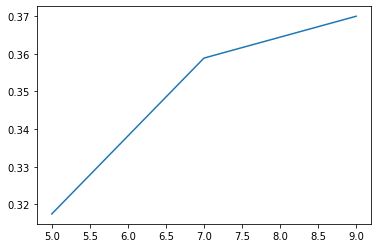

In [20]:
get_optimum_num_topics(5, 10)

### Retrain model

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=9,
                                            random_state=42,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

In [21]:
lda_model.print_topics(num_words=5)

[(0,
  '0.048*"new" + 0.020*"one" + 0.016*"time" + 0.014*"business" + 0.014*"story"'),
 (1,
  '0.060*"president" + 0.049*"trump" + 0.032*"state" + 0.020*"donald" + 0.017*"latest"'),
 (2,
  '0.032*"york" + 0.027*"market" + 0.023*"investor" + 0.023*"man" + 0.015*"global"'),
 (3,
  '0.094*"news" + 0.048*"world" + 0.034*"get" + 0.032*"top" + 0.032*"national"'),
 (4,
  '0.031*"two" + 0.024*"former" + 0.020*"officer" + 0.017*"show" + 0.015*"disney"'),
 (5,
  '0.020*"take" + 0.018*"magic" + 0.017*"photo" + 0.016*"shot" + 0.015*"hong"'),
 (6,
  '0.041*"say" + 0.041*"year" + 0.025*"police" + 0.019*"woman" + 0.018*"last"'),
 (7,
  '0.045*"week" + 0.038*"wednesday" + 0.018*"like" + 0.017*"canada" + 0.014*"told"'),
 (8,
  '0.021*"million" + 0.020*"minister" + 0.017*"prime" + 0.017*"china" + 0.014*"european"'),
 (9,
  '0.041*"said" + 0.038*"u" + 0.031*"thursday" + 0.019*"company" + 0.016*"three"')]

In [22]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=list_all_descriptions):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: x[1], reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [23]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=list_all_descriptions)

In [24]:
df_topic_sents_keywords

,Dominant_Topic,Perc_Contribution,Topic_Keywords,0
0,6.0,0.5448,"say, year, police, woman, last, ukraine, city,...","[national, transportation, safety, board, said..."
1,1.0,0.3476,"president, trump, state, donald, latest, staff...","[latest, monthly, figure, reflect, continued, ..."
2,5.0,0.3858,"take, magic, photo, shot, hong, kong, death, c...","[autumnwinter, collection, feature, designer, ..."
3,6.0,0.2967,"say, year, police, woman, last, ukraine, city,...","[han, first, north, korean, player, serie, pra..."
4,5.0,0.2100,"take, magic, photo, shot, hong, kong, death, c...","[uk, government, lawyer, david, johnston, argu..."
...,...,...,...,...
10408,3.0,0.5987,"news, world, get, top, national, video, find, ...","[get, breaking, national, world, news, broadca..."
10409,1.0,0.1752,"president, trump, state, donald, latest, staff...","[announcement, julius, baer, week, hired, five..."
10410,6.0,0.2283,"say, year, police, woman, last, ukraine, city,...","[weston, newswanger, normal, 5yearold, boy, ex..."
10411,0.0,0.3398,"new, one, time, business, story, hour, case, i...","[detective, haunted, case, two, woman, missing..."


In [25]:
df_topic_sents_keywords['Dominant_Topic'].value_counts()

9.0    2908
0.0    2231
6.0    1365
1.0     983
8.0     854
4.0     724
3.0     714
7.0     347
2.0     155
5.0     132
Name: Dominant_Topic, dtype: int64

In [27]:
df_topic_sents_keywords[df_topic_sents_keywords['Dominant_Topic'] == 1][0]

1        [latest, monthly, figure, reflect, continued, ...
34       [president, donald, trump, suggested, tuesday,...
37       [chief, staff, marc, short, said, suggestion, ...
39       [ash, 2019, england, jofra, archer, celebrates...
40       [pences, chief, staff, marc, short, said, deci...
                               ...                        
10375    [82000, raised, help, james, martin, injured, ...
10377    [global, antipoverty, nonprofit, oxfam, releas...
10386    [kurt, volker, resigned, last, week, named, wh...
10393    [top, european, court, ruled, facebook, intern...
10409    [announcement, julius, baer, week, hired, five...
Name: 0, Length: 983, dtype: object